In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import cv2

def read(name1):#name1 = ../input/animegirl-faces/face
    imgslist=[]
    for filename in os.listdir(name1):
        img = load_img(name1 + "/" + filename)
        img=np.array(img)
        imgslist.append(img)
    imgslist=np.array(imgslist)
    return(imgslist)

def resize_64(img):
    height, width = img.shape[:2]   
    size = (64,64)  
    shrink = cv2.resize(img, size, interpolation=cv2.INTER_AREA)  
    return shrink

def read2(name1):
    imgslist=[]
    for filename in os.listdir(name1):
        img = load_img(name1 + "/" + filename)
        img=np.array(img)
        img=resize_64(img)
        imgslist.append(img)
    imgslist=np.array(imgslist)
    return(imgslist)

In [4]:
imgslist=read2("images2")
print(imgslist.shape)

(63565, 64, 64, 3)


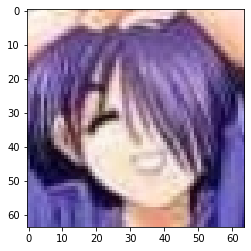

In [5]:
import matplotlib.pyplot as plt
plt.imshow(imgslist[0])

In [24]:
import keras
import tensorflow as tf
from keras import layers
from keras.activations import leaky_relu

Adam=keras.optimizers.adam_v2.Adam(learning_rate=0.0002,beta_1=0.5)

class DCGAN():
    def __init__(self,latent_dim=200,discriminator_path=-1,gan_path=-1):
        self.latent_dim=latent_dim
        self.generator=self.get_generator()
        if discriminator_path!=-1:
            self.discriminator=self.get_discriminator()
            self.discriminator.trainable=False
        else:
            self.discriminator=self.load_disciminator(discriminator_path)
        if gan_path!=-1:
            self.gan=keras.models.Sequential()
            self.gan.add(self.generator)
            self.gan.add(self.discriminator)
        else:
            self.gan=self.load_gan(gan_path)
        self.gan.compile(loss='binary_crossentropy', optimizer=Adam)
    
    def load_gan(self,model_path=-1):
        if model_path==-1:
            pass
        model=keras.models.load_model(model_path)
        return model
    def load_disciminator(self,model_path=-1):
        if model_path==-1:
            pass
        model=keras.models.load_model(model_path)
        model.compile(loss='binary_crossentropy', optimizer=Adam,metrics=["accuracy"])
        return model

    def get_discriminator(self):
        model=keras.models.Sequential()
        model.add(layers.Conv2D(32,3,1,"same",activation=leaky_relu,input_shape=(64,64,3)))
        model.add(layers.MaxPooling2D((2,2),2,"same"))
        model.add(layers.Conv2D(64,3,1,"same",activation=leaky_relu))
        model.add(layers.MaxPooling2D((2,2),2,"same"))
        model.add(layers.Conv2D(128,3,1,"same",activation=leaky_relu))
        model.add(layers.MaxPooling2D((2,2),2,"same"))
        model.add(layers.Conv2D(256,3,1,"same",activation=leaky_relu))
        model.add(layers.MaxPooling2D((2,2),2,"same"))
        model.add(layers.Conv2D(512,3,1,"same",activation=leaky_relu))
        model.add(layers.MaxPooling2D((2,2),2,"same"))
        model.add(layers.Conv2D(1024,3,1,"same",activation=leaky_relu))
        model.add(layers.MaxPooling2D((2,2),2,"same"))
        model.add(layers.Flatten())
        model.add(layers.Dense(32,activation="relu"))
        model.add(layers.Dense(1,activation="sigmoid"))
        model.compile(loss='binary_crossentropy', optimizer=Adam,metrics=["accuracy"])
        return model
    def get_generator(self):
        model=keras.models.Sequential()
        model.add(layers.Dense(1024,input_shape=(self.latent_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Reshape((1,1,1024)))
        model.add(layers.Conv2DTranspose(512,3,strides=(2,2),padding="same",activation=leaky_relu))
        model.add(layers.Conv2DTranspose(256,3,strides=(2,2),padding="same",activation=leaky_relu))
        model.add(layers.Conv2DTranspose(128,3,strides=(2,2),padding="same",activation=leaky_relu))
        model.add(layers.Conv2DTranspose(64,3,strides=(2,2),padding="same",activation=leaky_relu))
        model.add(layers.Conv2DTranspose(32,3,strides=(2,2),padding="same",activation=leaky_relu))
        model.add(layers.Conv2DTranspose(16,3,strides=(2,2),padding="same",activation=leaky_relu))
        model.add(layers.Conv2DTranspose(3,3,padding="same",activation="tanh"))
        return model

        """
        model = keras.models.Sequential()
        model.add(layers.Input(shape=self.latent_dim))
        model.add(layers.Dense(128*32*32))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Reshape((32,32,128)))
        model.add(layers.Conv2D(256,5,padding='same'))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Conv2DTranspose(256,4,strides=2,padding='same'))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Conv2D(256,5,padding='same'))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Conv2D(256,5,padding='same'))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Conv2D(3,7,activation='tanh',padding='same'))
        return model"""

    def save_fake(self,epoch):
        nums=tf.expand_dims(np.random.random(self.latent_dim), axis=0)
        img=self.generator(nums)
        print(img)
        img=np.reshape(img,(64,64,3))
        plt.imshow(img)
        plt.savefig("images/"+str(epoch)+".jpg")
    def train(self,data,epochs=5000,batch=64):
        data = (data.astype(np.float32)) /256
        half_batch = int(batch / 2)
        for epoch in range(epochs):
            nums1=np.random.rand(half_batch,self.latent_dim)
            nums2=np.random.rand(half_batch,self.latent_dim)
            idx=np.random.randint(0, data.shape[0], half_batch)
            real_img=np.array(data)[idx]
            real_labels=np.ones(half_batch)
            fake_img=self.generator.predict(nums1)
            fake_labels=np.zeros(half_batch)
            #print(real_img.shape)
            #print(fake_img.shape)

            d_loss1=self.discriminator.train_on_batch(real_img,real_labels)[0]
            d_loss2=self.discriminator.train_on_batch(fake_img,fake_labels)

            x=np.concatenate((real_img,fake_img))
            y=np.concatenate((real_labels,fake_labels))

            d_loss=d_loss1+d_loss2[0]
            gan_loss=self.gan.train_on_batch(nums2,real_labels)
            print("epochs:",str(epoch)," discriminator_loss:",str(d_loss),"discriminator_accuracy",str(d_loss2[1])," GAN_loss:",str(gan_loss))
            if epoch%500==0:
                #self.save_fake(epoch)
                fig, axs = plt.subplots(8, 8)
                cnt = 0
                for i in range(8):
                    for j in range(8):
                        axs[i, j].imshow(x[cnt, :, :, :])
                        axs[i, j].axis('off')
                        cnt += 1
                fig.savefig("images/{0:0>5}.png".format(epoch + 1), dpi=300)
                self.gan.save("models/"+"gan"+str(epoch)+".h5","w")
                self.discriminator.save("models/"+"disciriminator"+str(epoch)+".h5","w")


In [5]:
#DCGAN().gan.summary()

In [25]:
DCGAN(discriminator_path="models/disciriminator1500.h5",gan_path="models/gan1500.h5").train(data=imgslist)

epochs: 0  discriminator_loss: 1.3861268162727356 discriminator_accuracy 0.0  GAN_loss: 0.6918115615844727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

C

epochs: 1  discriminator_loss: 1.2181221842765808 discriminator_accuracy 0.0  GAN_loss: 0.6907982230186462

epochs: 2  discriminator_loss: 0.8958705216646194 discriminator_accuracy 0.0  GAN_loss: 0.6893669366836548

epochs: 3  discriminator_loss: 0.7025341773405671 discriminator_accuracy 0.0  GAN_loss: 0.6781907677650452

epochs: 4  discriminator_loss: 0.700949035352096 discriminator_accuracy 0.0  GAN_loss: 0.66075599193573

epochs: 5  discriminator_loss: 0.697219431574922 discriminator_accuracy 0.0  GAN_loss: 0.6405901908874512

epochs: 6  discriminator_loss: 0.6977033813018352 discriminator_accuracy 0.125  GAN_loss: 0.6676355004310608

epochs: 7  discriminator_loss: 0.688252390595153 discriminator_accuracy 1.0  GAN_loss: 0.6888839602470398

epochs: 8  discriminator_loss: 0.6767288576811552 discriminator_accuracy 1.0  GAN_loss: 0.8039140105247498

epochs: 9  discriminator_loss: 0.6489938027225435 discriminator_accuracy 1.0  GAN_loss: 1.1211283206939697

epochs: 10  discriminator_loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

C

epochs: 501  discriminator_loss: 1.2460157871246338 discriminator_accuracy 0.8125  GAN_loss: 1.182740569114685

epochs: 502  discriminator_loss: 1.4001513123512268 discriminator_accuracy 0.5  GAN_loss: 1.062483549118042

epochs: 503  discriminator_loss: 1.3355069756507874 discriminator_accuracy 0.46875  GAN_loss: 1.0325533151626587

epochs: 504  discriminator_loss: 1.2815494537353516 discriminator_accuracy 0.53125  GAN_loss: 0.9880271553993225

epochs: 505  discriminator_loss: 1.371050238609314 discriminator_accuracy 0.5625  GAN_loss: 0.9799239635467529

epochs: 506  discriminator_loss: 1.3596101999282837 discriminator_accuracy 0.28125  GAN_loss: 1.0473510026931763

epochs: 507  discriminator_loss: 1.3837270736694336 discriminator_accuracy 0.625  GAN_loss: 1.0832197666168213

epochs: 508  discriminator_loss: 1.4015381336212158 discriminator_accuracy 0.6875  GAN_loss: 0.9805437922477722

epochs: 509  discriminator_loss: 1.2810672521591187 discriminator_accuracy 0.625  GAN_loss: 0.964060

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

C

epochs: 1001  discriminator_loss: 0.4811321645975113 discriminator_accuracy 0.875  GAN_loss: 1.8752446174621582

epochs: 1002  discriminator_loss: 0.6219943463802338 discriminator_accuracy 0.875  GAN_loss: 1.8532063961029053

epochs: 1003  discriminator_loss: 0.42783913016319275 discriminator_accuracy 0.96875  GAN_loss: 2.0215346813201904

epochs: 1004  discriminator_loss: 0.8837902247905731 discriminator_accuracy 0.75  GAN_loss: 2.3757402896881104

epochs: 1005  discriminator_loss: 0.8497830033302307 discriminator_accuracy 1.0  GAN_loss: 1.7530009746551514

epochs: 1006  discriminator_loss: 1.211981400847435 discriminator_accuracy 0.5625  GAN_loss: 2.573549747467041

epochs: 1007  discriminator_loss: 0.768191784620285 discriminator_accuracy 1.0  GAN_loss: 1.9623624086380005

epochs: 1008  discriminator_loss: 0.7897550463676453 discriminator_accuracy 0.8125  GAN_loss: 1.895716667175293

epochs: 1009  discriminator_loss: 0.5651205480098724 discriminator_accuracy 0.9375  GAN_loss: 2.0605

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

C

epochs: 1501  discriminator_loss: 0.44052064418792725 discriminator_accuracy 0.9375  GAN_loss: 2.6396994590759277

epochs: 1502  discriminator_loss: 0.6383759379386902 discriminator_accuracy 0.96875  GAN_loss: 2.527796745300293

epochs: 1503  discriminator_loss: 0.5946743935346603 discriminator_accuracy 0.84375  GAN_loss: 2.594083309173584

epochs: 1504  discriminator_loss: 0.27471330016851425 discriminator_accuracy 1.0  GAN_loss: 2.7369613647460938

epochs: 1505  discriminator_loss: 0.8748281300067902 discriminator_accuracy 0.75  GAN_loss: 3.120173692703247

epochs: 1506  discriminator_loss: 0.7012556493282318 discriminator_accuracy 1.0  GAN_loss: 2.6326282024383545

epochs: 1507  discriminator_loss: 0.49301666021347046 discriminator_accuracy 0.96875  GAN_loss: 2.616124153137207

epochs: 1508  discriminator_loss: 0.2996443957090378 discriminator_accuracy 1.0  GAN_loss: 2.603210926055908

epochs: 1509  discriminator_loss: 0.6383914053440094 discriminator_accuracy 0.71875  GAN_loss: 3.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

C